<a id='top'></a>
<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/>

# NIRSpec MOS Slits to Sky

**Authors**: Dan Coe (dcoe@stsci.edu) and Kayli Glidic (kglidic@stsci.edu) with contributions from others on the STScI NIRSpec team. <br>
**Created On**: June, 2024 ([JWebbinar 33](https://www.stsci.edu/jwst/science-execution/jwebbinars.html#h3-dc1c3cd6-f1aa-45c4-b73f-e93cc96ff4a7:~:text=33%20%2D%20JWST%20NIRSpec%20MOS%20Data%20Reduction))<br>
**Updated On**: October, 2025. <br>

**Purpose**:<br> The primary goal of this notebook is to demonstrate how to map Near Infrared Spectrograph (NIRSpec) Multi-Object Spectroscopy (MOS) slits to the sky and back. 

**[Data](#data)**:<br>
This notebook is set up to use the [ERO 2736](https://www.stsci.edu/cgi-bin/get-proposal-info?observatory=JWST&id=2736) G395M observations of [SMACS0723](https://webbtelescope.org/contents/news-releases/2022/news-2022-035), source 6355 (z = 7.665), plus a few others.

---

## Table of Contents
* [1. Introduction](#intro)
* [2. Import Library](#imports)
* [3. Helper Functions](#funcs)
* [4. Download the Data](#data)
* [5. Load in the Data](#load)
    * [5.1 NIRSpec Spectra](#load_spectra)
        * [5.1.1 Extract the Wavelength Grid](#wave_grid)
    * [5.2 MSA Metafile](#load_msa)
    * [5.3 NIRCam Images](#load_nircam)
* [6. Define the Slit Sizes](#'slit_sizes)
* [7. Mapping Slits to the Sky](#mapping)
* [8. Mapping Sky back to Slits](#mapping_2)
* [9. Show Image Alongside Spectrum](#final)




---
  
## 1. Introduction <a id='intro'></a>

This notebook demonstrates how to map NIRSpec MSA slits to the sky and back.

We also show how to extract the wavelength grid from either the S2D or X1D pipeline products.

Finally we show the 2D and 1D spectra alongside the color image with slits overlaid, rotated to the orientation of the 2D spectrum.

We use the ERO 2736 G395M observations of SMACS0723, source 6355 (z = 7.665).

#### Inputs
* NIRSpec `CAL`, `S2D`, and `X1D` files for this object from `Spec3Pipeline`
* NIRSpec MSA metafile
* NIRCam image from the [DJA](https://dawn-cph.github.io/dja/index.html)
    * https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits.gz
* NIRCam color image produced using [Trilogy](https://github.com/dancoe/trilogy) (optional)
    * https://relics.stsci.edu/data/smacs0723-73/JWST/smacs0723_color_sw.png
    * alternatively, you could show a single filter image in grayscale
    
    
#### Outputs
* Slits drawn on (color) image.
* Image mapped back to slit frame.


---

## 2. Import Library <a id='imports'></a>


In [1]:
# General imports.
import gzip  # Decompress .gz files.
import os
import shutil
import warnings

import numpy as np
import requests  # Download large files.
import tqdm  # Shows progress bar while downloading files.

In [2]:
# Import JWST datamodels.
from jwst import datamodels

In [3]:
# Astropy imports.
import astropy
import astropy.units as u
import astropy.wcs as wcs
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.utils.exceptions import AstropyWarning
print('astropy', astropy.__version__)

# Astroquery imports.
import astroquery
from astroquery.mast import Observations  # MAST
print('astroquery version', astroquery.__version__)

astropy 7.1.0
astroquery version 0.4.10


In [4]:
# To plot and view results.
import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from astropy.stats import sigma_clip  # , SigmaClip
from astropy.visualization import simple_norm, LinearStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [5]:
# Color image.
import PIL  # Python Image Library.
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # Allow it to load large image.

---

## 3. Helper Functions <a id='funcs'></a>

These functions handle downloading and decompressing data files.

In [6]:
def decompress_file(filename,
                    decompressed_file=''):
    """
    Decompress the given file to a new file.

    Parameters
    ----------
    filename : str
        Name of the file to be decompressed.
    decompressed_file : str
        Name of the file in which to save the decompressed data.

    Returns
    -------
    None.
    """
    decompressed_file = decompressed_file or filename[:-3]
    print('Decompressing to:', decompressed_file, '...')
    
    with gzip.open(filename, 'rb') as f_in:
        with open(decompressed_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Clean up: remove compressed file, now that you've decompressed it.
    if os.path.exists(filename):
        if os.path.getsize(filename):
            os.remove(filename)


def download_large_file(url,
                        filename='',
                        decompress=True):
    """
    Download a large file from a given URL, and decompress.

    Parameters
    ----------
    url : str
        URL of the file to be downloaded.
    filename : str
        Name of the file in which to save the downloaded data.
    decompress : bool
        Whether or not to attempt to decompress the file.

    Returns
    -------
    filename : str
        Name of the file containing the downloaded data.
    """
    if filename:
        if os.path.isdir(filename):
            filename = os.path.join(filename, os.path.basename(url))
        # else just use the filename as is
    else:
        filename = os.path.basename(url)  # if left blank, just save the filename as in the URL

    decompressed_file = filename
    if decompress:
        if filename[-3:] == '.gz':
            decompressed_file = filename[:-3]
        elif url[-3:] == '.gz':
            filename += '.gz'
    
    if os.path.exists(decompressed_file):
        if os.path.getsize(decompressed_file):
            print(decompressed_file, 'EXISTS')
            return decompressed_file
    
    print('Downloading', url)
    print('to:', filename)
    #print('(d)', decompressed_file)

    with open(filename, 'wb') as f:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))

            # tqdm has many interesting parameters. Feel free to experiment!
            tqdm_params = {
                #'desc': url,
                'total': total,
                'miniters': 1,
                'unit': 'B',
                'unit_scale': True,
                'unit_divisor': 1024,
                'bar_format': '{l_bar}{bar:20}{r_bar}{bar:-20b}',  # progress bar length 20 pixels
            }
            with tqdm.tqdm(**tqdm_params) as pb:
                for chunk in r.iter_content(chunk_size=8192):
                    pb.update(len(chunk))
                    f.write(chunk)
                      
    if decompress:
        if filename[-3:] == '.gz':
            decompress_file(filename, decompressed_file)        
            filename = decompressed_file
            
    return filename


# Helper function to download JWST files from MAST.
def download_jwst_files(filenames,
                        download_dir,
                        mast_dir='mast:JWST/product'):
    """
    Helper function to download JWST files from MAST.

    Parameters:
    ----------
    filenames: list of str
        List of filenames to download.
    download_dir: str
        Directory where the files will be downloaded.
    mast_dir: str
        MAST directory containing JWST products.

    Returns:
    -------
    downloaded_files: list of str
        List of downloaded file paths.
    """
    # Download data.
    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename = os.path.basename(filename)
        mast_path = os.path.join(mast_dir, filename)
        local_path = os.path.join(download_dir, filename)
        if os.path.exists(local_path):
            print(local_path, 'EXISTS')
        else:
            # Can let this command check if local file exists.
            # However, it will delete it if it's there
            # and the wrong size (e.g., reprocessed).
            print('downloading...')
            print(mast_path)
            print(local_path)
            result = Observations.download_file(mast_path, local_path=local_path, verbose=True)
            print(result)
        downloaded_files.append(local_path)

    return downloaded_files

Basic math and logic functions.

In [7]:
def between(lo, x, hi):
    """
    Determine if a given value is between a high and a low value.

    Parameters
    ----------
    lo : float
        Lower boundary value.
    x : float
        Value to be checked.
    hi : float
        High boundary value.

    Returns
    -------
    value : bool
        True if x is between lo and hi, otherwise False.
    """
    return (lo <= x) * (x <= hi)


def roundint(x):
    """
    Round the given number to the nearest integer.

    Parameters
    ----------
    x : float
        Value to be rounded.

    Returns
    -------
    value : int
        Rounded value.
    """
    return int(np.round(x))


def single_value(x):
    """
    Determine whether the input is a single integer or float.
    True = one number; False = multiple numbers (list / tuple / array / set).

    Parameters
    ----------
    x : int, float, list, tup, etc

    Returns
    -------
    value : bool
        True if x is an integer or float. Otherwise false.
    """
    return isinstance(x, (int, float))

Functions for array slicing and table filtering.


In [8]:
def slices_extent(x, y, dx, dy=0):
    """
    Generate slice objects based on given x, y values and dx, dy lengths.

    Parameters
    ----------
    x : int
        X value of the central coordinate.
    y : int
        Y value of the central coordinate.
    dx : int
        Half-width in the x direction.
    dy : int
        Half-width in the y direction.

    Returns
    -------
    slices : tup
        Tuple of y- and x-slice objects.
    extent : tup
        4-tuple of low and high coordinates for both x and y.
    """
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

def filter_table(full_table, **kwargs):
    """
    Filters an Astropy Table based an arbitrary number of input column-value pairs.
    Each value can be either a single value or a list (or tuple, array, or set).
    Example:
    select_shutter_table = filter_table(shutter_table, msa_metadata_id=1, dither_point_index=1, source_id=[6355,5144])

    Parameters
    ----------
    full_table : astropy.table.Table
        Table to be filtered.
    
    Returns
    -------
    filtered_table : astropy.table.Table
        Table containing only requested columns/values.
    """
    filtered_table = full_table
    for column, value in kwargs.items():
        if single_value(value):
            filtered_table = filtered_table[filtered_table[column] == value]
        else: # list
            filtered_table = filtered_table[[(item in value) for item in filtered_table[column]]]
    return filtered_table

---

## 4. Download the Data <a id='data'></a>

The script will download these automatically from MAST and the other links below:
* NIRSpec `CAL`, `S2D`, and `X1D` files for this object from `Spec3Pipeline`
* NIRSpec MSA metafile
* NIRCam image from the [DJA](https://dawn-cph.github.io/dja/index.html)
    * https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits.gz
* NIRCam color image produced using [Trilogy](https://github.com/dancoe/trilogy) (optional)
    * https://relics.stsci.edu/data/smacs0723-73/JWST/smacs0723_color_sw.png
    * alternatively, you could show a single filter image in grayscale
    


In [9]:
# Define data directory.
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

First, we will download the NIRSpec `CAL`, `S2D`, and `X1D` files for a specific source from MAST. You may also choose to load in files you've reprocessed.

In [10]:
# Select a source_id to download and examine.
source_id = 6355  # z = 7.665
#source_id = 4590  # z = 8.498
#source_id = 10612  # z = 7.663
#source_id = 9922  # z = 2.743

In [11]:
# Define the S2D spectrum filename.
cal_file = 'jw02736-o007_s%09d_nirspec_f290lp-g395m_cal.fits' % source_id
print("The CAL file is:", cal_file)

# Download 2D spectrum.
cal_file = download_jwst_files([cal_file], data_dir)[0]
cal_file

The CAL file is: jw02736-o007_s000006355_nirspec_f290lp-g395m_cal.fits
data/jw02736-o007_s000006355_nirspec_f290lp-g395m_cal.fits EXISTS


'data/jw02736-o007_s000006355_nirspec_f290lp-g395m_cal.fits'

In [12]:
# Download 2D rectified spectrum.
s2d_file = cal_file.replace('cal', 's2d')
s2d_file = download_jwst_files([s2d_file], data_dir)[0]
s2d_file

data/jw02736-o007_s000006355_nirspec_f290lp-g395m_s2d.fits EXISTS


'data/jw02736-o007_s000006355_nirspec_f290lp-g395m_s2d.fits'

In [13]:
# Download 1D spectrum.
x1d_file = s2d_file.replace('s2d', 'x1d')
x1d_file = download_jwst_files([x1d_file], data_dir)[0]
x1d_file

data/jw02736-o007_s000006355_nirspec_f290lp-g395m_x1d.fits EXISTS


'data/jw02736-o007_s000006355_nirspec_f290lp-g395m_x1d.fits'

Next, we will grab the MSA metadata file name from the header of the `S2D` file and download it.

In [14]:
# Get name of MSA metafile from S2D file header.
msa_metafile = fits.getval(s2d_file, 'MSAMETFL')
print(f"The MSA metadata file name is = {msa_metafile}")

# Download MSA metafile.
msa_metafile = download_jwst_files([msa_metafile], data_dir)[0]
msa_metafile

The MSA metadata file name is = jw02736007001_01_msa.fits
data/jw02736007001_01_msa.fits EXISTS


'data/jw02736007001_01_msa.fits'

Finally, we will download the NIRCam data. 

The NIRCam color image was created with [Trilogy](https://github.com/dancoe/trilogy)
using [NIRCam images in the DAWN JWST Archive (DJA)](https://dawn-cph.github.io/dja/imaging/v7/). This is optional.

Alternatively, you can show a single filter image in grayscale.

In [15]:
# Download a color image if you have one.
# It should be on the same pixel grid as the FITS image you'll download next after this.

showing_color_image = True  # Controls the plotting later.

# Trilogy NIRCam SW color image (226 MB).
color_image_file = 'https://relics.stsci.edu/data/smacs0723-73/JWST/smacs0723_color_sw.png'
color_image_file = download_large_file(color_image_file, data_dir)
color_image_file

data/smacs0723_color_sw.png EXISTS


'data/smacs0723_color_sw.png'

In [16]:
# Load single filter FITS image for WCS header to convert RA, Dec -> x, y.
# NIRCam F200W FITS image from DJA (371 MB).
NIRCam_image_file = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits.gz'
NIRCam_image_file = download_large_file(NIRCam_image_file, data_dir)
NIRCam_image_file

data/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits EXISTS


'data/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits'

---

## 5. Load in the Data <a id='load'></a>

In this section, we will load in the data for the NIRSpec spectra and metadata, as well as the NIRCam images.

---

### 5.1 NIRSpec Spectra <a id='load_spectra'></a>

Use JWST datamodels to hold the data.

In [17]:
# Open the CAL file and extract the data.
cal_model = datamodels.open(cal_file)

# Locate the data for the object with the requested source_id.
if 'slits' in list(cal_model) and cal_model.slits:  # Spec2 S2D has all the objects; extract the one with source_id.
    source_ids = [slit.source_id for slit in cal_model.slits]
    i_slit = source_ids.index(source_id)
    slit_model_cal = cal_model.slits[i_slit]
else:  # Spec3 S2D only has one object or slits is empty.
    slit_model_cal = cal_model.exposures[0]
    i_slit = 0

cal_data = slit_model_cal.data + 0  # Load and make copy.

# Replace zeros with nan where there is no data.
cal_data = np.where(slit_model_cal.err, cal_data, np.nan)


In [18]:
# Open the S2D file and extract the data.
s2d_model = datamodels.open(s2d_file)
#s2d_model.info(max_rows=99999)  # Show all contents.
#s2d_data = s2d_model.data + 0

# Locate the data for the object with the requested source_id.
if 'slits' in list(s2d_model):  # Spec2 s2d has all the objects; extract the one with source_id.
    source_ids = [slit.source_id for slit in s2d_model.slits]
    i_slit = source_ids.index(source_id)
    slit_model_s2d = s2d_model.slits[i_slit]
else:  # Spec3 s2d only has one object
    slit_model_s2d = s2d_model
    i_slit = 0

s2d_data = slit_model_s2d.data + 0  # Load and make copy.

# Replace zeros with nan where there is no data
s2d_data = np.where(slit_model_s2d.err, s2d_data, np.nan)


In [19]:
# Load 1D extraction.
x1d_model = datamodels.open(x1d_file)
#x1d_model.info(max_rows=99999)  # Show all contents.

---

#### 5.1.1 Extract the Wavelength Grid <a id='wave_grid'></a>

We can extract the wavelength grid directly from the `S2D` datamodel after running the [*`assign_wcs`*](https://jwst-pipeline.readthedocs.io/en/latest/_modules/jwst/assign_wcs/nirspec.html) step. The `S2D` model includes a World Coordinate System (WCS) transform from detector coordinates to world coordinates — specifically: RA, Dec, and wavelength.

In [20]:
# WCS transformations.
slit_wcs = slit_model_s2d.meta.wcs
det_to_sky = slit_wcs.get_transform('detector', 'world')  # Coordinate transform from detector pixels to sky.
slit_to_sky = slit_wcs.get_transform('slit_frame', 'world')
sky_to_slit = slit_wcs.get_transform('world', 'slit_frame')

In [21]:
y_s2d, x_s2d = np.mgrid[:s2d_data.shape[0], :s2d_data.shape[1]]  # Grid of pixel x, y indices.
ra_s2d, dec_s2d, s2d_waves = det_to_sky(x_s2d, y_s2d)  # RA, Dec, wavelength (microns) for each pixel.
ra_s2d = ra_s2d[:, 0]  # RA, Dec only defined in the spatial cross-dispersion direction.
dec_s2d = dec_s2d[:, 0] # RA, Dec only defined in the spatial cross-dispersion direction.
s2d_wave = s2d_waves[0, :] # Wavelength only defined in the dispersion direction.
# Every row is identical in the rectified spectrum.
s2d_wave

array([2.84863722, 2.85043148, 2.85222575, ..., 5.28289045, 5.28467829,
       5.28646621], shape=(1215,))

Alternatively, we can extract the wavelength grid directly from the `X1D` file as shown below. The `S2D` spectrum is on the same wavelength grid.

In [22]:
x1d_wave = x1d_model.spec[i_slit].spec_table.WAVELENGTH
x1d_wave  # Identical to s2d_wave below.

array([2.8486371 , 2.85043144, 2.85222578, ..., 5.28289032, 5.28467846,
       5.28646612], shape=(1215,))

**Note**: Starting with JWST pipeline version 1.16, the WCS in the `S2D` files produces an infinitely thin slit when projected onto the sky, so we will use the `CAL` files instead to project the full width of the shutters. Therefore, all transforms used moving forward in this notebook will be taken from the `CAL` file.

In [23]:
# WCS transformations.
slit_wcs = slit_model_cal.meta.wcs
det_to_sky = slit_wcs.get_transform('detector', 'world')  # Coordinate transform from detector pixels to sky.
slit_to_sky = slit_wcs.get_transform('slit_frame', 'world')
sky_to_slit = slit_wcs.get_transform('world', 'slit_frame')

---

### 5.2 MSA Metafile <a id='load_msa'></a>

Load the MSA metadata file to extract information about the observed sources. We list out a few things below, but for a detailed walkthrough on MSA metadata files, see the [JDAT GitHub repository](https://github.com/spacetelescope/jdat_notebooks/tree/main).


In [24]:
# Load MSA metafile and inspect contents
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: data/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     35   1318R x 13C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A, 7A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [25]:
# Extract the shutter and source tables.
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)
source_table = Table(msa_hdu_list['SOURCE_INFO'].data)
#msa_hdu_list['SHUTTER_IMAGE'].data.shape


In [26]:
# The MSA metadata file can have multiple MSA configs.
set(shutter_table['msa_metadata_id'])

{np.int16(1), np.int16(76)}

In [27]:
# Print out the number of dithers.
dithers = list(set(shutter_table['dither_point_index']))
dithers

[np.int16(1), np.int16(2), np.int16(3)]

In [28]:
# Print out all source_ids in the shutter table.
source_ids = set(shutter_table['source_id'])
source_ids = np.sort(list(source_ids))
source_ids

array([   -62,    -61,    -60,    -59,    -58,    -57,    -56,    -55,
          -54,    -53,    -52,    -51,    -50,    -49,    -48,    -47,
          -46,    -45,    -44,    -43,    -42,    -41,    -40,    -39,
          -38,    -37,    -36,    -35,    -34,    -33,    -32,    -31,
          -30,    -29,    -28,    -27,    -26,    -25,    -24,    -23,
          -22,    -21,    -20,    -19,    -18,    -17,    -16,    -15,
          -14,    -13,    -12,    -11,    -10,     -9,     -8,     -7,
           -6,     -5,     -4,     -3,     -2,     -1,      0,   1370,
         1679,   1917,   2038,   2572,   2653,   3042,   3772,   4580,
         4590,   4592,   4798,   4805,   5144,   5735,   5992,   6113,
         6355,   7570,   7677,   8140,   8277,   8311,   8312,   8498,
         8506,   8717,   8730,   8883,   8886,   8981,   9239,   9483,
         9721,   9922,  10380,  10389,  10390,  10392,  10444,  10511,
        10612, 101449, 102423, 102539, 102673, 102711, 102730, 102738,
      

In [29]:
# Filter the source table for the requested source_id.
select_source_table = filter_table(source_table, source_id=source_id)
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,0.1


In [30]:
# Get the source RA and Dec.
source_ra = select_source_table['ra'][0]
source_dec = select_source_table['dec'][0]
source_ra, source_dec

(np.float64(110.84459416965377), np.float64(-73.4350589621277))

In [31]:
# Filter the shutter table for the requested source_id.
source_shutter_table = filter_table(shutter_table, dither_point_index=1, msa_metadata_id=1, source_id=source_id)
source_shutter_table

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source,fixed_slit
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1,str7
72,1,3,138,83,6355,Y,OPEN,nan,nan,1,N,NONE
72,1,3,138,84,6355,N,OPEN,0.46437824,0.86562544,1,Y,NONE
72,1,3,138,85,6355,Y,OPEN,nan,nan,1,N,NONE
72,1,3,138,86,6355,Y,OPEN,nan,nan,1,N,NONE
72,1,3,138,87,6355,Y,OPEN,nan,nan,1,N,NONE


In [32]:
# Get the primary index for the source in the slitlet.
i_primary = list(source_shutter_table['primary_source']).index('Y')
i_primary

1

---

### 5.3 NIRCam Images <a id='load_nircam'></a>

Load in the NIRCam data.

In [33]:
# Load in the NIRCam FITS file.
image_hdulist = fits.open(NIRCam_image_file)
idata = 0

# Extract the WCS information.
image_wcs = wcs.WCS(image_hdulist[idata].header, image_hdulist)
image_hdulist.close()
image_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 110.83403 -73.45429 
CRPIX : 9182.5 13030.5 
CD1_1 CD1_2  : -5.5555555555555e-06 0.0 
CD2_1 CD2_2  : 0.0 5.5555555555555e-06 
NAXIS : 24000  24000

In [34]:
# Load in the NIRCam color image or single filter image.
if showing_color_image:
    im = Image.open(color_image_file)
    im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
    NIRCam_image = np.asarray(im)
    # Takes a few seconds to load a large image.   

else:
    # Just load single image.
    NIRCam_image = fits.getdata(NIRCam_image_file)

---

## 6. Define the Slit Sizes <a id='slit_sizes'></a>

Before mapping the slits to the sky, let's define the physical dimensions of the MSA slits.

In [35]:
open_slit_x_size = 0.20  # Open slit width in arcseconds (dispersion direction).
open_slit_y_size = 0.46  # Open slit height in arcseconds (cross-dispersion direction).
slit_bar_width = 0.07  # The bar width=height in arcseconds (between the slits).
open_slit_aspect = open_slit_y_size / open_slit_x_size  # Aspect ratio of open slit.

# Define the full slit size including the bar width.
full_slit_x_size = open_slit_x_size + slit_bar_width
full_slit_y_size = open_slit_y_size + slit_bar_width
full_slit_aspect = full_slit_y_size / full_slit_x_size  # Aspect ratio of full slit.
print(f"Full slit size: width = {full_slit_x_size:.2f} arcsec, height = {full_slit_y_size:.2f} arcsec.")

Full slit size: width = 0.27 arcsec, height = 0.53 arcsec.


In [36]:
# Scale factors from open slit to full slit size (including bars) in x and y directions.
x_scale_open_to_full = full_slit_x_size / open_slit_x_size
y_scale_open_to_full = full_slit_y_size / open_slit_y_size
print(f"Scale factors (open to full slit): x = {x_scale_open_to_full:.2f}, y = {y_scale_open_to_full:.2f}")

Scale factors (open to full slit): x = 1.35, y = 1.15


In [37]:
# Slit corners in coordinates that range from (0,0) to (1,1).
# Order of corners: bottom-left, top-left, top-right, bottom-right.
open_slit_x_corners = 0, 0, 1, 1 
open_slit_y_corners = 0, 1, 1, 0

# Convert coordinates to slit centroid at (0,0).
open_slit_x_corners = np.array(open_slit_x_corners) - 0.5
open_slit_y_corners = np.array(open_slit_y_corners) - 0.5

# Convert to full slit (not just open area).
full_slit_x_corners = x_scale_open_to_full * open_slit_x_corners
full_slit_y_corners = y_scale_open_to_full * open_slit_y_corners

# Print the full slit corners as (x, y) pairs relative to the slit centroid
print("Full slit corners (x, y):", list(zip(full_slit_x_corners, full_slit_y_corners)))

Full slit corners (x, y): [(np.float64(-0.675), np.float64(-0.5760869565217391)), (np.float64(-0.675), np.float64(0.5760869565217391)), (np.float64(0.675), np.float64(0.5760869565217391)), (np.float64(0.675), np.float64(-0.5760869565217391))]


---

## 7. Mapping Slits to the Sky <a id='mapping'></a>


In the next few cells, we will map the slits to the sky. First, from the MSA metadata file, extract the estimated source position in the shutter.

In [38]:
# MSA metafile estimate of source position within shutter slitlet.
# Coordinates range from (0,0) to (1,1).
estimated_source_in_shutter_x = source_shutter_table['estimated_source_in_shutter_x'][i_primary]
estimated_source_in_shutter_y = source_shutter_table['estimated_source_in_shutter_y'][i_primary]
#estimated_source_in_shutter_x, estimated_source_in_shutter_y

# Convert coordinates to slit centroid at (0,0).
estimated_source_in_shutter_x -= 0.5
estimated_source_in_shutter_y -= 0.5

# Coordinates are actually for full slit (not just open area).
# Scale to full slit size.
estimated_source_in_shutter_x *= x_scale_open_to_full
estimated_source_in_shutter_y *= y_scale_open_to_full

# Transform to sky (RA,Dec) using S2D WCS transformation.
estimated_source_ra, estimated_source_dec, zero = slit_to_sky(
    estimated_source_in_shutter_x, estimated_source_in_shutter_y, 0)

# Transform to image pixels (x,y) using image WCS.
estimated_source_coordinates = SkyCoord(ra=estimated_source_ra*u.deg, dec=estimated_source_dec*u.deg)
estimated_source_x, estimated_source_y = image_wcs.world_to_pixel(estimated_source_coordinates)

print(f"Estimated source position: RA = {estimated_source_ra:.6f} deg, Dec = {estimated_source_dec:.6f} deg")
print(f"Estimated source pixel location: x = {estimated_source_x:.2f}, y = {estimated_source_y:.2f}")

Estimated source position: RA = 110.844591 deg, Dec = -73.435049 deg
Estimated source pixel location: x = 8639.52, y = 16492.86


In [39]:
# Indices to iterate along slit with multiple shutters.
# (e.g., dy_columns = -1,0,1 for 3-shutter slitlet).
dx_rows = source_shutter_table['shutter_row'] - source_shutter_table['shutter_row'][i_primary]
dy_columns = source_shutter_table['shutter_column'] - source_shutter_table['shutter_column'][i_primary]

# Scale to full slit (not just open area).
dx_slit = np.array(dx_rows) * x_scale_open_to_full
dy_slit = np.array(dy_columns) * y_scale_open_to_full
# Note the cross-dispersion direction is defined as columns in the MSA metafile.
# even though we normally show them as rows in the MSA.
dy_slit  

array([-1.15217391,  0.        ,  1.15217391,  2.30434783,  3.45652174])

In [40]:
# Calculate offset between S2D WCS transformation and actual coordinates in input catalog.
# The input catalog coordinates (RA, Dec) are more accurate.
source_coordinates = SkyCoord(ra=source_ra*u.deg, dec=source_dec*u.deg)
source_x, source_y = image_wcs.world_to_pixel(source_coordinates)

# Calculate offset.
# We'll correct for this offset below.
dx_obs = estimated_source_x - source_x
dy_obs = estimated_source_y - source_y

# Print the pixel offset between estimated and catalog positions.
print(f"Offset between estimated and catalog source position: Δx = {dx_obs:.2f} px, Δy = {dy_obs:.2f} px")

Offset between estimated and catalog source position: Δx = 0.15 px, Δy = 1.82 px


In [41]:
# Convert full slit corner coordinates to sky using S2D WCS transformation (slit_to_sky),
# then convert those sky positions to image pixel coordinates using the image WCS.
xx = []
yy = []

for i in range(len(dy_columns)):
    # Apply spatial offset for each shutter in the slitlet.
    slitlet_ra, slitlet_dec, zero = slit_to_sky(full_slit_x_corners + dx_slit[i], full_slit_y_corners + dy_slit[i], 0)

    # Create SkyCoord object from RA/Dec.
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)

    # Convert sky coordinates to image pixel coordinates.
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)

    # Save corner positions for each shutter.
    xx.append(x)
    yy.append(y)

# Define the image stamp region: a 3"x3" square around the center of the slits.
dx = 75  # Half-width in pixels (0.02" * 75 pixels = 1.5", so the image will be 3"x3").
slices, extent = slices_extent(np.mean(xx), np.mean(yy), dx)
xlo, xhi, ylo, yhi = extent

# Print the center of the slitlet in pixel coordinates.
print(f"Center of slitlet region: x = {np.mean(xx):.2f}, y = {np.mean(yy):.2f}")

Center of slitlet region: x = 8626.04, y = 16482.51


Plot the MSA slitlet on the sky.

In [42]:
slit_color = 'r'  # open
full_slit_color = 'gray'
source_color = (0, 0.8, 0)  # green

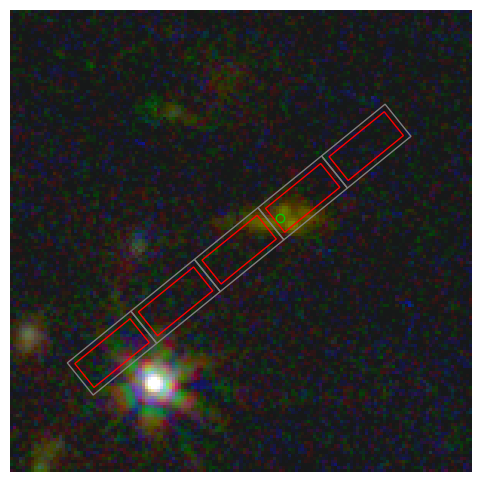

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))

# Plot the NIRCam image.
if showing_color_image:
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower')
else:  # grayscale
    norm = simple_norm(NIRCam_image[slices], 'asinh', percent=99)
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower', cmap='gray', norm=norm)

# Plot source position from input catalog.
plt.plot(source_x, source_y, 'o', mec=source_color, mfc='None')

# Plot the slitlet shutters.
for i in range(len(source_shutter_table)):
    # Plot open slit area.
    slitlet_ra, slitlet_dec, zero = slit_to_sky(open_slit_x_corners + dx_slit[i], open_slit_y_corners + dy_slit[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    xy = np.array([x-dx_obs, y-dy_obs]).T  # correction
    patch = matplotlib.patches.Polygon(xy, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

    # Plot full slit area including half bar.
    full_slitlet_ra, full_slitlet_dec, zero = slit_to_sky(
        x_scale_open_to_full * open_slit_x_corners + dx_slit[i], 
        y_scale_open_to_full * open_slit_y_corners + dy_slit[i], 0)
    full_slit_coordinates = SkyCoord(ra=full_slitlet_ra*u.deg, dec=full_slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(full_slit_coordinates)
    xy = np.array([x-dx_obs, y-dy_obs]).T  # correction
    patch = matplotlib.patches.Polygon(xy, fc='None', ec=full_slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

ax.axis('off')  # Hide the axis coordinates, ticks, and labels.
plt.show()

#### Show the correction that enabled this

The slits (RA, Dec) derived from the `CAL` WCS transform is a bit off.  
Taking it at face value, we estimate the source position (RA, Dec) based on the estimated position within the slit, which is more accurate.  
We compare this to actual source position (RA, Dec) from the catalog in the MSA file.  
We use the offset to correct the slit positions (RA, Dec).

In [44]:
wcs_slit_color = 'gray'
wcs_source_color = 'g'

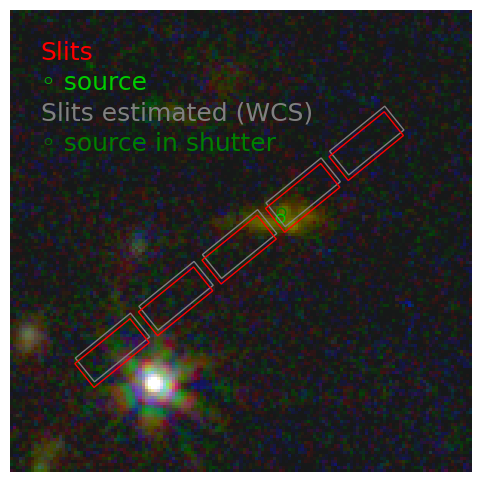

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))

if showing_color_image:
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower')
else:
    norm = simple_norm(NIRCam_image[slices], 'asinh', percent=99)
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower', cmap='gray', norm=norm)

plt.plot(estimated_source_x, estimated_source_y, 'o', mec=wcs_source_color, mfc='None')
plt.plot(source_x, source_y, 'o', mec=source_color, mfc='None')

for i in range(len(source_shutter_table)):
    # Slit coordinates from WCS transform.
    slitlet_ra, slitlet_dec, zero = slit_to_sky(open_slit_x_corners + dx_slit[i], open_slit_y_corners + dy_slit[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    wcs_slit_x, wcs_slit_y = image_wcs.world_to_pixel(slit_coordinates)
    wcs_slit_xy = np.array([wcs_slit_x, wcs_slit_y]).T
    patch = matplotlib.patches.Polygon(wcs_slit_xy, fc='None', ec=wcs_slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

    # Correction.
    slit_x = wcs_slit_x - dx_obs
    slit_y = wcs_slit_y - dy_obs
    slit_xy = np.array([slit_x, slit_y]).T
    patch = matplotlib.patches.Polygon(slit_xy, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

plt.text(xlo+10, yhi-10, 'Slits',                 color=slit_color,       va='top', fontsize=18)
plt.text(xlo+10, yhi-20, '◦ source',              color=source_color,     va='top', fontsize=18)
plt.text(xlo+10, yhi-30, 'Slits estimated (WCS)', color=wcs_slit_color,   va='top', fontsize=18)
plt.text(xlo+10, yhi-40, '◦ source in shutter',   color=wcs_source_color, va='top', fontsize=18)

ax.axis('off')  # Hide the axis coordinates, ticks, and labels.
plt.show()

Now show the `S2D` spatial cross-dispersion direction mapped to sky (RA, Dec).

In [46]:
s2d_coordinates = SkyCoord(ra=ra_s2d*u.deg, dec=dec_s2d*u.deg)
s2d_x, s2d_y = image_wcs.world_to_pixel(s2d_coordinates)
s2d_x -= dx_obs
s2d_y -= dy_obs

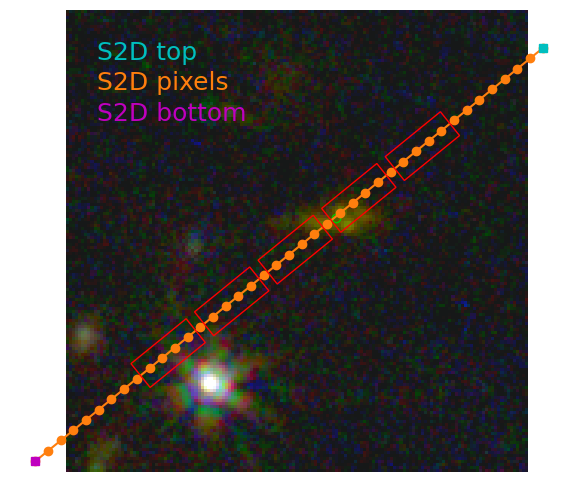

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))

if showing_color_image:
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower')
else:
    norm = simple_norm(NIRCam_image[slices], 'asinh', percent=99)
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower', cmap='gray', norm=norm)

plt.plot(source_x, source_y, 'o', mec=source_color, mfc='None')

for i in range(len(source_shutter_table)):
    slitlet_ra, slitlet_dec, zero = slit_to_sky(open_slit_x_corners + dx_slit[i], open_slit_y_corners + dy_slit[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    xy = np.array([x-dx_obs, y-dy_obs]).T
    patch = matplotlib.patches.Polygon(xy, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

plt.plot(s2d_x, s2d_y, '-o')
plt.plot(s2d_x[-1], s2d_y[-1], 's', color='c')
plt.plot(s2d_x[0],  s2d_y[0],  's', color='m')

plt.text(xlo+10, yhi-10, 'S2D top',    color='c',  va='top', fontsize=18)
plt.text(xlo+10, yhi-20, 'S2D pixels', color='C1', va='top', fontsize=18)
plt.text(xlo+10, yhi-30, 'S2D bottom', color='m',  va='top', fontsize=18)

ax.axis('off')  # Hide the axis coordinates, ticks, and labels.
plt.show()

---

## 8. Mapping Sky back to Slits <a id='mapping_2'></a>


In [48]:
# Use full extent of S2D in spatial cross-dispersion direction.
slit_x, slit_y, zero = sky_to_slit(ra_s2d, dec_s2d, 0)  # Slit coordinates.
y_slit_lo = slit_y[0]
y_slit_hi = slit_y[-1]
y_slit_lo, y_slit_hi

# Single slit width + some padding in the dispersion direction.
x_slit_hi = 1.2  # 1.0 is just the open slit + half bar; add extra for padding.
x_slit_lo = - (x_slit_hi - 1)
x_slit_lo, x_slit_hi = x_slit_hi, x_slit_lo  # Need to transpose?

print('x:', x_slit_lo, x_slit_hi)
print('y:', y_slit_lo, y_slit_hi)

x: 1.2 -0.19999999999999996
y: 5.863673315014569 -3.3357047368723483


In [49]:
# Create a high-resolution coordinate grid spanning that extent in the slit plane.
nx_slit_image = 100
ny_slit_image = nx_slit_image * full_slit_aspect * (y_slit_hi - y_slit_lo)
y_slit, x_slit = np.mgrid[y_slit_lo:y_slit_hi:ny_slit_image*1j, x_slit_lo:x_slit_hi:nx_slit_image*1j] - 0.5
x_slit *= x_scale_open_to_full
y_slit *= y_scale_open_to_full
ny_slit, nx_slit = y_slit.shape

# Transform these coordinates to the image plane.
ra_slit, dec_slit, zero = slit_to_sky(x_slit, y_slit, 0)
coords_slit = SkyCoord(ra=ra_slit*u.deg, dec=dec_slit*u.deg)
x_image, y_image = image_wcs.world_to_pixel(coords_slit)

# Extract the image values (colors) at each coordinate.
slit_stamp = NIRCam_image[np.round(y_image-dy_obs).astype(int), np.round(x_image-dx_obs).astype(int)]
if np.all(slit_stamp == slit_stamp[0]):  # All the same value probably means no data.
    slit_stamp = 128 + 0 * slit_stamp  # Make gray for no data.

slit_extent = x_slit[0, 0], x_slit[0, -1], y_slit[0, 0], y_slit[-1, 0]

In [50]:
# If dithered, then show extra background slitlets on either side.
slit_bkg_color = 0.88, 0.7, 0.7  # light red
extend_length = int(dithers[-1] - np.mean(dithers))
dy_columns_extended = np.arange(dy_columns[0]-extend_length, dy_columns[-1]+extend_length+1)
dy_columns_extended

array([-2, -1,  0,  1,  2,  3,  4])

(np.float64(0.945),
 np.float64(-0.945),
 np.float64(6.17988447164722),
 np.float64(-4.4193989359616195))

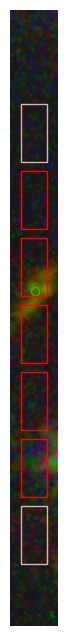

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(2, 8))

# Show image;  don't bother checking if it's color or grayscale:
# cmap will be ignored for color image; and automatic linear scaling could be okay in this region
ax.imshow(slit_stamp, origin='lower', aspect=open_slit_aspect, extent=slit_extent, cmap='gray')

# Draw slits
for dy in dy_columns_extended:
    if between(dy_columns[0], dy, dy_columns[-1]):
        color = slit_color
    else: # background dithers
        color = slit_bkg_color
    xy_corners = np.array([open_slit_x_corners, open_slit_y_corners + dy * y_scale_open_to_full]).T
    patch = matplotlib.patches.Polygon(xy_corners, fc='None', ec=color, alpha=1, zorder=100)
    ax.add_patch(patch)

plt.plot(estimated_source_in_shutter_x, estimated_source_in_shutter_y, 'o', mec=source_color, mfc='None')

plt.axis('off')  # hide the axis coordinates, ticks, and labels

---

## 9. Show Image Alongside Spectrum <a id='final'></a>

The figures below show:

* **Left panel**: Imaging data around the source, with the shutter outline and estimated source position marked. This indicates where the source falls on the sky and within the slit.
* **Top-right panel**: The 2D spectrum, with wavelength along the horizontal axis and the spatial direction along the slit on the vertical axis. Since the spectra have been background-subtracted, negative flux regions appear in red.
* **Bottom-right panel**: The 1D extracted spectrum. The blue line shows the source flux as a function of wavelength, while the red line represents the flux uncertainty at each wavelength.

First let's define some helper plotting functions.

In [52]:
def extract_slit_from_table(source_id,
                            slit_to_sky):
    """
    Calculate location information for the given source_id using 
    the provided coordinate transform function.

    Parameters
    ----------
    source_id : int
        Source ID number

    slit_to_sky : astropy.modeling.core.CompoundModel
        WCS transform from the slit frame to sky coordinates

    Returns
    -------
    i_primary : int
        Primary source number
        
    dy_columns : astropy.table.Column
        Column of shutter values
        
    dx_obs : float
        Difference in x-direction between estimated source location and actual source location
        
    dy_obs : float
        Difference in y-direction between estimated source location and actual source location
        
    estimated_source_in_shutter_x : float
        Estimated x location of source within the shutter
    
    estimated_source_in_shutter_y : float
        Estimated y location of source within the shutter
    """
    source_shutter_table = filter_table(shutter_table, dither_point_index=1, msa_metadata_id=1, source_id=source_id)
    if not source_shutter_table:
        return []
    
    i_primary = list(source_shutter_table['primary_source']).index('Y')

    select_source_table = source_table[source_table['source_id'] == source_id]
    source_ra = select_source_table['ra'][0]
    source_dec = select_source_table['dec'][0]

    estimated_source_in_shutter_x = source_shutter_table['estimated_source_in_shutter_x'][i_primary]
    estimated_source_in_shutter_y = source_shutter_table['estimated_source_in_shutter_y'][i_primary]

    # Shift coordinate centroid to (0,0)
    estimated_source_in_shutter_x -= 0.5
    estimated_source_in_shutter_y -= 0.5

    # Coordinates are actually for full slit (not just open area)
    estimated_source_in_shutter_x *= x_scale_open_to_full
    estimated_source_in_shutter_y *= y_scale_open_to_full

    # Transform to sky (RA,Dec) using S2D WCS transformation
    estimated_source_ra, estimated_source_dec, zero = slit_to_sky(
        estimated_source_in_shutter_x, estimated_source_in_shutter_y, 0)

    # Transform to image pixels (x,y) using image WCS
    estimated_source_coordinates = SkyCoord(ra=estimated_source_ra*u.deg, dec=estimated_source_dec*u.deg)
    estimated_source_x, estimated_source_y = image_wcs.world_to_pixel(estimated_source_coordinates)

    # Calculate offset between S2D WCS transformation and actual coordinates in input catalog
    # The input catalog coordinates (RA,Dec) are more accurate than the pipeline (RA,Dec)
    source_coordinates = SkyCoord(ra=source_ra*u.deg, dec=source_dec*u.deg)
    source_x, source_y = image_wcs.world_to_pixel(source_coordinates)

    # We'll correct for this offset below
    dx_obs = estimated_source_x - source_x
    dy_obs = estimated_source_y - source_y

    # Indices to iterate along slit with multiple shutters
    # (e.g., dy_columns = -1,0,1 for 3-shutter slitlet)
    #dx_rows = source_shutter_table['shutter_row'] - source_shutter_table['shutter_row'][i_primary]
    dy_columns = source_shutter_table['shutter_column'] - source_shutter_table['shutter_column'][i_primary]

    # Scale to full slit (not just open area)
    # No, do this later
    #dx_rows    = np.array(dx_rows)    * x_scale_open_to_full
    #dy_columns = np.array(dy_columns) * y_scale_open_to_full

    # Note the cross-dispersion direction is defined as columns in the MSA metafile
    # even though we normally show them as rows in the MSA

    return i_primary, dy_columns, dx_obs, dy_obs, estimated_source_in_shutter_x, estimated_source_in_shutter_y

In [53]:
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w', expand_wavelength_gap=True,
                      plot_image=True, save_plot=False, save_dir='plots', figsize=(12, 6), x_slit_hi=1.2,
                      sigma_2d=5,  maxiters_2d=3,  # 2D spectrum clipping.
                      ymargin_1d_pos=1.1,  # margin above max
                      sigma_1d_pos=1000, maxiters_1d_pos=1,  # 1D spectrum clipping
                      sigma_1d_neg=10,   maxiters_1d_neg=3,  # 1D spectrum clipping
                      ymin=None, ymax=None, wave_tick_interval=0.2, wave_tick_fmt='%.1f'):
    """
    Create and show a figure containing an image of the 2D spectrum, alongside a plot of the 1D spectrum,
    for the given source. Also show the source in the imaging mode data, with shutter locations overplotted.

    Parameters
    ----------
    s2d_model : stdatamodels.jwst.datamodels.slit.SlitModel
        Datamodel containing 2D cutouts of source spectra
    x1d_model : stdatamodels.jwst.datamodels.multispec.MultiSpecModel
        Datamodel containing 1D spectra
    source_id : int
        Source ID number
    cmap : str
        Colormap
    bad_color : str
        Color to use for bad pixels
    expand_wavelength_gap : bool
        If there is a wavelength gap in the data, expand the data arrays to sample the gap.
    plot_image : bool
        Whether or not to create the figure
    save_plot : bool
        Whether or not to save the figure to a file
    save_dir : str
        Output directory for saved figure
    figsize : tup
        2-tuple of the matplotlib figure size
    x_slit_hi : float
    sigma_2d : int
        Sigma value for 2D spectrum clipping
    maxiters_2d : int
        Number of iterations for 2D spectrum clipping
    ymargin_1d_pos : float
        Fraction of the maximum 1D data point to use for the upper y-limit of the 1D spectrum plot
    sigma_1d_pos : int
        Sigma value for 1D spectrum clipping
    maxiters_1d_pos : int 
        Number of iterations for 1D spectrum clipping
    sigma_1d_neg : int
        Sigma value for 1D negative spectrum clipping
    maxiters_1d_neg : int
        Number of iterations for 1D negative spectrum clipping
    ymin : float
        Lower limit in y-direction for 1D spectrum plot
    ymax : float
        Upper limit in y-direction for 1D spectrum plot
    wave_tick_interval : float
        Interval for wavelength ticks
    wave_tick_fmt : str
        Format for wavelength tick labels
    """
    # 2D spectrum
    if 'slits' in list(s2d_model):  # s2d from Spec2 has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d from Spec3 has only one object from one detector
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data

    # Expand the wavelength array for the gap?
    if expand_wavelength_gap:
        # calculate differences between consecutive wavelengths and
        # find if there is a gap to fill
        dx1d_wave = x1d_wave[1:] - x1d_wave[:-1]
        igap = np.argmax(dx1d_wave)
        dx1d_max = np.max(dx1d_wave)
        dx_replace = (dx1d_wave[igap-1] + dx1d_wave[igap+1]) / 2.
        num_fill = int(np.round(dx1d_max / dx_replace))
        print("Expanding wavelength gap %.2f -- %.2f microns"
              % (x1d_wave[igap], x1d_wave[igap+1]))

        if num_fill > 1:  # There is a gap to fill
            wave_fill = np.mgrid[x1d_wave[igap]: x1d_wave[igap+1]: (num_fill+1)*1j]
            x1d_wave = np.concatenate([x1d_wave[:igap+1], wave_fill[1:-1], x1d_wave[igap+1:]])

            num_rows, num_waves = s2d_data.shape
            s2d_fill = np.zeros(shape=(num_rows, num_fill-1)) * np.nan
            s2d_data = np.concatenate([s2d_data[:, :igap+1], s2d_fill, s2d_data[:, igap+1:]], axis=1)

            x1d_fill = np.zeros(shape=(num_fill-1)) * np.nan
            x1d_flux = np.concatenate([x1d_flux[:igap+1], x1d_fill, x1d_flux[igap+1:]])
            x1d_fluxerr = np.concatenate([x1d_fluxerr[:igap+1], x1d_fill, x1d_fluxerr[igap+1:]])

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    xtick_min = np.ceil((wave_min - eps) / wave_tick_interval) * wave_tick_interval
    xticks = np.arange(xtick_min, wave_max, wave_tick_interval)
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = [wave_tick_fmt % xtick for xtick in xticks]

    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''

    # WCS transformations
    slit_wcs = slit_model.meta.wcs
    det_to_sky = slit_wcs.get_transform('detector', 'world') # coordinate transform from detector pixels to sky 
    slit_to_sky = slit_wcs.get_transform('slit_frame', 'world')
    sky_to_slit = slit_wcs.get_transform('world', 'slit_frame')

    # Extract slit from tables
    slit_list = extract_slit_from_table(source_id, slit_to_sky)
    
    if slit_list and plot_image:
    
        i_primary, dy_columns, dx_obs, dy_obs, \
            estimated_source_in_shutter_x, estimated_source_in_shutter_y = slit_list        

        # Make FIGURE
        fig = plt.figure(figsize=figsize)
        grid = plt.GridSpec(2, 2, width_ratios=[1, 12*1.2/x_slit_hi], height_ratios=[1, 3], wspace=0.02, hspace=0.12)

        ax_image = fig.add_subplot(grid[:, 0])
        ax_2d = fig.add_subplot(grid[0, 1])
        ax_1d = fig.add_subplot(grid[1, 1], sharex=ax_2d)

        # IMAGE
        ax_image.axis('off')
    
        y_s2d = np.arange(s2d_data.shape[0]) # grid of pixel y indices: spatial cross-dispersion
        x_s2d = y_s2d * 0  # dispersion direction irrelevant for RA, Dec
        ra_s2d, dec_s2d, s2d_waves = det_to_sky(x_s2d, y_s2d) # RA, Dec, wavelength (microns) for each pixel 
        slit_x, slit_y, zero = sky_to_slit(ra_s2d, dec_s2d, 0)  # slit coordinates

        y_slit_lo = slit_y[0]
        y_slit_hi = slit_y[-1]

        # x_slit_hi = 1.2  # 1.0 is just the slit + half bar; add extra for padding
        x_slit_lo = - (x_slit_hi - 1)
        x_slit_lo, x_slit_hi = x_slit_hi, x_slit_lo  # need to transpose?

        # Create a high-resolution coordinate grid in the slit plane
        nx_slit_image = 100
        ny_slit_image = nx_slit_image * full_slit_aspect * (y_slit_hi - y_slit_lo)
        y_slit, x_slit = np.mgrid[y_slit_lo:y_slit_hi:ny_slit_image*1j, x_slit_lo:x_slit_hi:nx_slit_image*1j] - 0.5
        x_slit *= x_scale_open_to_full
        y_slit *= y_scale_open_to_full
        ny_slit, nx_slit = y_slit.shape

        # Transform these to the image plane
        ra_slit, dec_slit, zero = slit_to_sky(x_slit, y_slit, 0)
        coords_slit = SkyCoord(ra=ra_slit*u.deg, dec=dec_slit*u.deg)
        x_image, y_image = image_wcs.world_to_pixel(coords_slit)

        # Extract the image values (colors) at each coordinate
        slit_stamp = NIRCam_image[np.round(y_image-dy_obs).astype(int), np.round(x_image-dx_obs).astype(int)]
        if np.all(slit_stamp == slit_stamp[0]):  # all the same value probably means no data
            slit_stamp = 128 + 0 * slit_stamp  # make gray for no data
            
        slit_extent = x_slit[0, 0], x_slit[0, -1], y_slit[0, 0], y_slit[-1, 0]
        #print('ymin, xmin', np.min(y_image-dy_obs), np.min(x_image-dx_obs))
        #print(source_id, i_primary, dy_columns, dx_obs, dy_obs)

        # Plot image
        ax_image.imshow(slit_stamp, origin='lower', aspect=open_slit_aspect, extent=slit_extent)
    
        dy_columns_extended = list(dy_columns) + [dy_columns[0] - 1] + [dy_columns[-1] + 1]

        for dy in dy_columns_extended:
            #print('dy', dy)
            if between(dy_columns[0], dy, dy_columns[-1]):
                color = slit_color
            else:
                color = slit_bkg_color
            xy_corners = np.array([open_slit_x_corners, open_slit_y_corners + dy * y_scale_open_to_full]).T
            patch = matplotlib.patches.Polygon(xy_corners, fc='None', ec=color, alpha=1, zorder=100)
            ax_image.add_patch(patch)

        ax_image.plot(estimated_source_in_shutter_x, estimated_source_in_shutter_y, 'o', mec=source_color, mfc='None')

    else: 
        # Make FIGURE -- no image
        fig = plt.figure(figsize=figsize)
        grid = plt.GridSpec(2, 1, height_ratios=[1, 3], wspace=0.03, hspace=0.1)

        #ax_image = fig.add_subplot(grid[:, 0])
        ax_2d = fig.add_subplot(grid[0])
        ax_1d = fig.add_subplot(grid[1], sharex=ax_2d)

    # 2D spectrum
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', AstropyWarning)
        sigma_clipped_data = sigma_clip(s2d_data, sigma=sigma_2d, maxiters=maxiters_2d)
    ymin_2d = np.min(sigma_clipped_data)
    ymax_2d = np.max(sigma_clipped_data)
    print('2D limits:', ymin_2d, ymax_2d)

    # Plot the rectified 2D spectrum
    norm = ImageNormalize(vmin=ymin_2d, vmax=ymax_2d, stretch=LinearStretch())
    #norm = simple_norm(s2d_data, 'linear', vmin=ymin_2d, vmax=ymax_2d)
    ax_2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    ny, nx = s2d_data.shape
    ax_2d.yaxis.set_ticks_position('right')

    # Plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax_1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax_1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax_1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax_1d.set_xlim(0, num_waves)
    ax_1d.yaxis.set_ticks_position('right')

    if sigma_1d_pos:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', AstropyWarning)
            sigma_clipped_data = sigma_clip(x1d_flux, sigma=sigma_1d_pos, maxiters=maxiters_1d_pos)
        ymax_1d = np.max(sigma_clipped_data) * ymargin_1d_pos

        with warnings.catch_warnings():
            warnings.simplefilter('ignore', AstropyWarning)
            sigma_clipped_data = sigma_clip(x1d_flux, sigma=sigma_1d_neg, maxiters=maxiters_1d_neg)
        ymin_1d = np.min(sigma_clipped_data)
        
        print('1D limits:', ymin_1d, ymax_1d)
        ax_1d.set_ylim(ymin_1d, ymax_1d)

    if ymin or ymax:
        ax_1d.set_ylim(ymin, ymax)
        
    s2d_filename = os.path.basename(s2d_model.meta.filename) 
    title = s2d_filename.replace('_s2d.fits', '')
    title = title.replace('_', '  ')
    title += '  slit %d' % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax_2d.set_title(title)
    plt.xticks(xtick_pos, xtick_labels)
    ax_2d.set_yticks([0, (ny-1)/2., ny-1])
    ax_2d.tick_params(labelbottom=False)  # Hide x-axis labels on the 2D plot
    ax_1d.set_xlabel('wavelength (microns)')
    
    if save_plot:
        outfile = s2d_filename.replace('_s2d.fits', '.png')
        os.makedirs(save_dir, exist_ok=True)
        outfile = os.path.join(save_dir, outfile)
        print('SAVING', outfile)
        plt.savefig(outfile, dpi=200, bbox_inches='tight')
    else:
        plt.show()

Plot the source of interest.

Expanding wavelength gap 4.70 -- 4.96 microns
2D limits: -0.2847915291786194 0.2778046131134033
1D limits: -5.721150699818262e-07 1.1381397431150474e-06


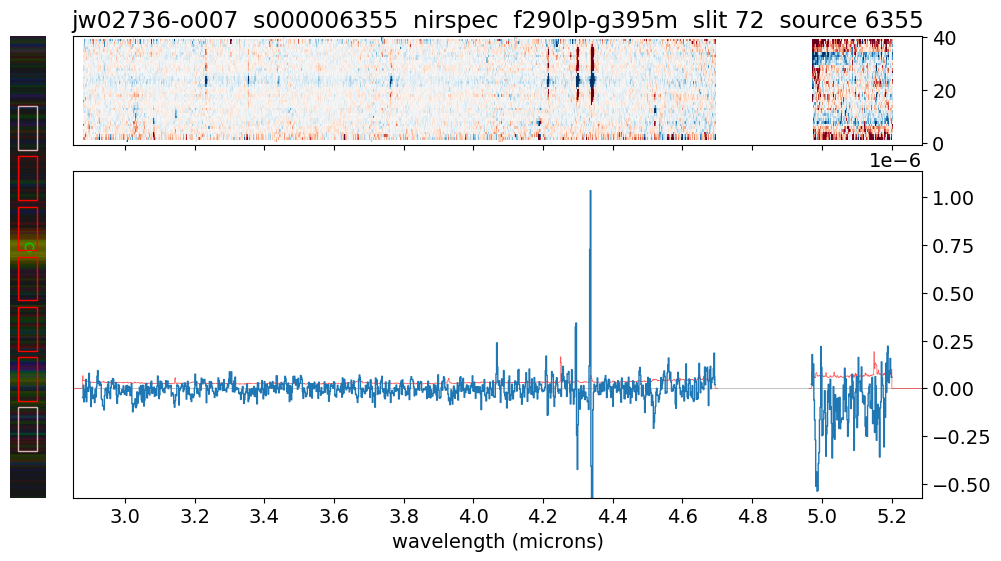

In [54]:
show_MOS_spectrum(s2d_model, x1d_model, source_id)  # , save_plot=True)

Now, load and display different sources.

In [55]:
def load_and_show_MOS_spectrum(source_id):
    """
    Wrapper function to download an S2D and X1D file for a particular source_id,
    get the data, and display the 1D and 2D spectra along with the imaging data.

    Parameters
    ----------
    source_id : int
        Source ID number
    """
    s2d_file = 'jw02736-o007_s%09d_nirspec_f290lp-g395m_s2d.fits' % source_id
    s2d_file = download_jwst_files([s2d_file], data_dir)[0]
    s2d_model = datamodels.open(s2d_file)
    
    x1d_file = s2d_file.replace('s2d', 'x1d')
    x1d_file = download_jwst_files([x1d_file], data_dir)[0]
    x1d_model = datamodels.open(x1d_file)
    
    show_MOS_spectrum(s2d_model, x1d_model, source_id)  # , save_plot=True)

data/jw02736-o007_s000006355_nirspec_f290lp-g395m_s2d.fits EXISTS
data/jw02736-o007_s000006355_nirspec_f290lp-g395m_x1d.fits EXISTS
Expanding wavelength gap 4.70 -- 4.96 microns
2D limits: -0.2847915291786194 0.2778046131134033
1D limits: -5.721150699818262e-07 1.1381397431150474e-06


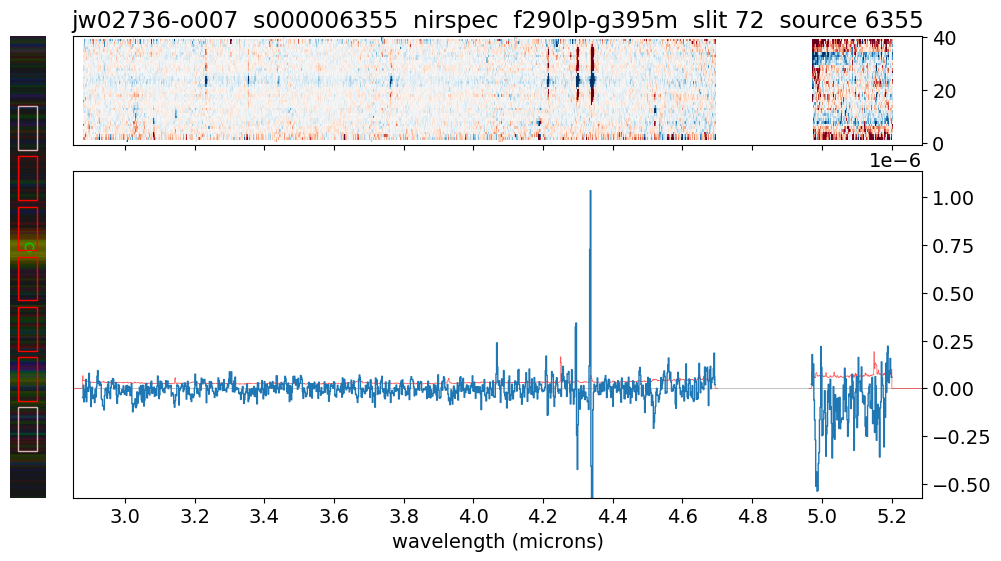

In [56]:
source_id = 6355  # z = 7.665
load_and_show_MOS_spectrum(source_id)  # z = 7.665

data/jw02736-o007_s000010612_nirspec_f290lp-g395m_s2d.fits EXISTS
data/jw02736-o007_s000010612_nirspec_f290lp-g395m_x1d.fits EXISTS
Expanding wavelength gap 4.60 -- 4.86 microns
2D limits: -0.3277970850467682 0.31918951869010925
1D limits: -4.818729982401629e-07 6.4970677679377405e-06


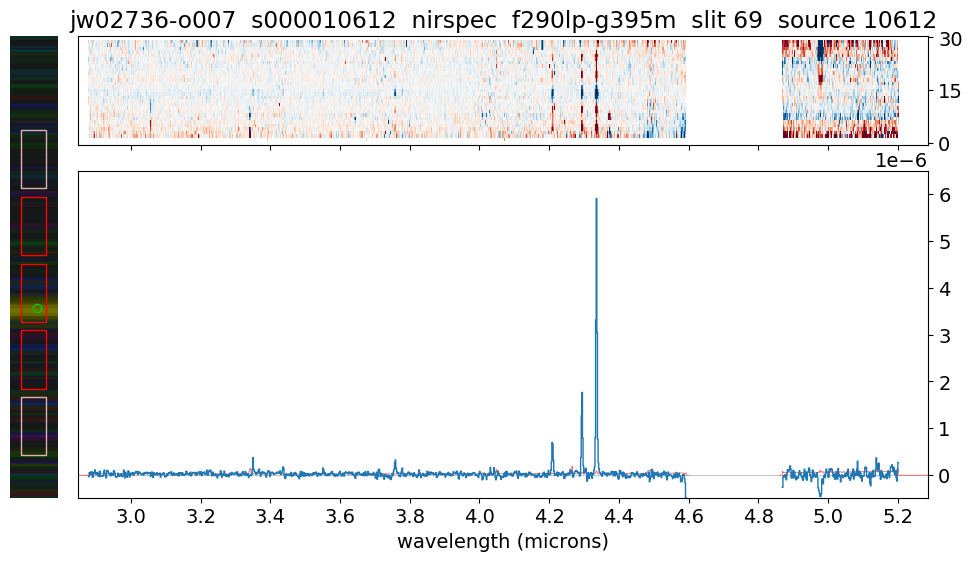

In [57]:
load_and_show_MOS_spectrum(10612)  # z = 7.663

data/jw02736-o007_s000009922_nirspec_f290lp-g395m_s2d.fits EXISTS
data/jw02736-o007_s000009922_nirspec_f290lp-g395m_x1d.fits EXISTS
Expanding wavelength gap 4.45 -- 4.72 microns
2D limits: -0.43249109387397766 0.39361676573753357
1D limits: -2.1530491755780886e-07 1.4785926173661602e-06


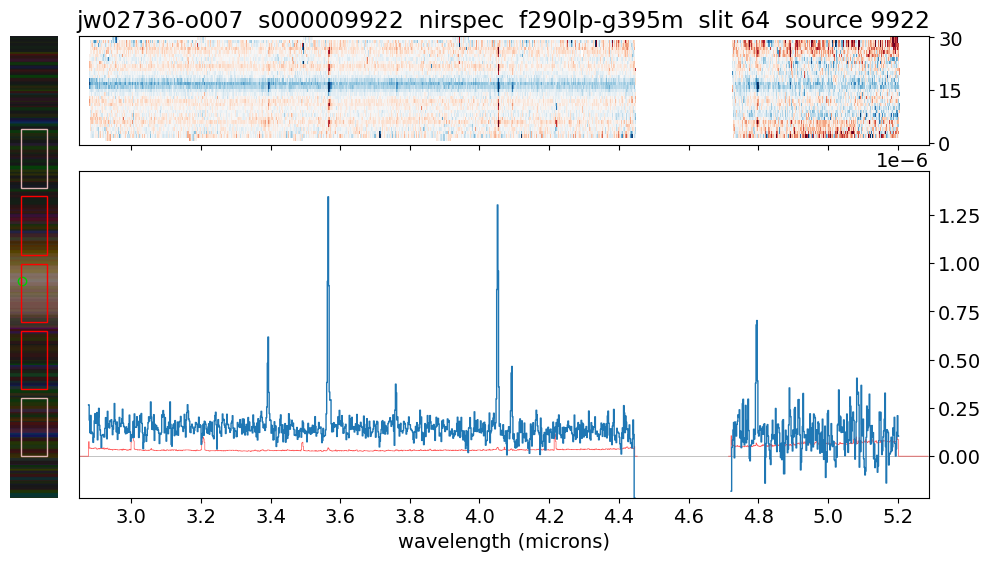

In [58]:
load_and_show_MOS_spectrum(9922)  # z = 2.743


---

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

[Top of Page](#top)   